# Biological Learning
A pytorch implementation of [Paper](https://www.pnas.org/content/116/16/7723), largely based on code provided by the author in this [Notebook](https://github.com/DimaKrotov/Biological_Learning/blob/master/Unsupervised_learning_algorithm_MNIST.ipynb)

In [7]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test)= cifar10.load_data() #https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz


#For CNN
classes = 10
in_dim = (32, 32, 3)

y_train = to_categorical(y_train, classes)
y_test = to_categorical(y_test, classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255

# for i in x_train:
i = x_train[0]
for x in i:
    print("\n\n")
    for y in x:
        print(y)




[0.23137255 0.24313726 0.24705882]
[0.16862746 0.18039216 0.1764706 ]
[0.19607843 0.1882353  0.16862746]
[0.26666668 0.21176471 0.16470589]
[0.38431373 0.28627452 0.20392157]
[0.46666667 0.35686275 0.24705882]
[0.54509807 0.41960785 0.29411766]
[0.5686275  0.43137255 0.3137255 ]
[0.58431375 0.45882353 0.34901962]
[0.58431375 0.47058824 0.3647059 ]
[0.5137255  0.40392157 0.3019608 ]
[0.49019608 0.3882353  0.29803923]
[0.5568628  0.4509804  0.35686275]
[0.5647059 0.4392157 0.3372549]
[0.5372549  0.4117647  0.30980393]
[0.5058824  0.38039216 0.2784314 ]
[0.5372549  0.41568628 0.30980393]
[0.5254902  0.41568628 0.29803923]
[0.4862745  0.38039216 0.2509804 ]
[0.54509807 0.44313726 0.30588236]
[0.54509807 0.4392157  0.29411766]
[0.52156866 0.4117647  0.27058825]
[0.53333336 0.4117647  0.2901961 ]
[0.54509807 0.42352942 0.3019608 ]
[0.59607846 0.47058824 0.34901962]
[0.6392157  0.5137255  0.39215687]
[0.65882355 0.53333336 0.42352942]
[0.62352943 0.5058824  0.4       ]
[0.61960787 0.509803

In [44]:
fig = plt.figure(figsize=(12.9,10))
device = "cuda"
eps0 = 2e-2    # initial learning rate
Kx = 15
Ky = 15
hid = Kx*Ky    # number of hidden units
mu = 0.0       # mean for initialization
sigma = 1.0    # SD for initialization
epochs = 200   # number of epochs
minibatch_size = 100      # size of the minibatch
prec = 1e-30   # Machine eps
delta = 0.4    # Strength of the anti-hebbian learning
p = 2.0        # Lebesgue norm of the weights
k = 2          # ranking parameter, must be integer that is bigger or equal than 2

<Figure size 928.8x720 with 0 Axes>

In [45]:
def draw_weights(synapses, Kx, Ky):
    yy=0
    HM=np.zeros((28*Ky,28*Kx))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)
            yy += 1
    plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    plt.axis('off')
    fig.canvas.draw()
    
def draw_neuron(synapses, row = 0, random = False):
    if random:
        choices = synapses.shape[0]
        row = np.random.randint(choices)
    HM=synapses[row, :]
    plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM.reshape((28, 28)),cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    plt.axis('off')
    plt.title(str(row) + "th Neuron")
    fig.canvas.draw()
    plt.show()

This is the implementation of the appoximation

In [46]:
%matplotlib inline
synapses = np.random.normal(mu, sigma, (hid, 32, 32, 3))

for epoch in range(epochs):
    eps = eps0 * ( 1 - epoch / epochs)
    print("\n================\n", epoch, "th epoch, epsilon = ", eps)
    M = M[np.random.permutation(samples),:]
    
    for i in range(samples // minibatch_size):
        #Take the ith row, make it a column
        inputs = np.transpose(M[i * minibatch_size:(i + 1) * minibatch_size, :])
        
        #take the sign of each synapse 
        sig = np.sign(synapses)
        
        #dot product of the synapses * inputs 
        tot_input = np.dot(sig * np.absolute(synapses) ** (p-1), inputs)
        
        #returns matrix of same size with each column ranked 0-99
        y = np.argsort(tot_input,axis=0)
        
        #creates new matrix of same shape to populate
        yl = np.zeros((hid, minibatch_size))

        #populating the hid columns and the number of the batch size as 1
        yl[y[hid-1,:], np.arange(minibatch_size)] = 1.0
        yl[y[hid-k], np.arange(minibatch_size)] = -delta
        
        #infinity norm(sum of rows) of theelementwise multiplication
        xx = np.sum(np.multiply(yl, tot_input),1)
        
        #dot product of new matrix with the inputs
        A = np.dot(yl, np.transpose(inputs))
        
        C = np.tile(xx.reshape(xx.shape[0], 1), (1, in_dim))
        
        #matrix mutliplication of synapses with tiled xx
        B = np.multiply(C, synapses)
        ds =  A - B

        #max absolute of DS
        nc = np.amax(np.absolute(ds))
        
        #Change this for float32
        if nc < prec:
            nc = prec
            
        #adds a small value to the synapses matrix
        synapses += eps*np.true_divide(ds, nc)
        
    draw_neuron(synapses)    


 0 th epoch, epsilon =  0.02


IndexError: index 58385 is out of bounds for axis 0 with size 50000

In [ ]:
%matplotlib inline
plt.imshow(synapses[200].reshape((28, 28)), interpolation='nearest')
plt.show()

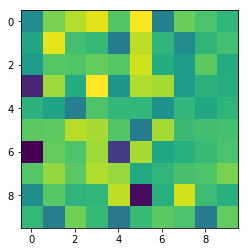

In [48]:
%matplotlib inline
out = np.matmul(synapses, test)
plt.imshow(out.reshape(10, 10), interpolation='nearest')
plt.show()

In [30]:
dat = mat['data'][1]
for x in np.nditer(dat):
    row = x // 96
    position = x % 96
    
    
    

In [32]:
dat.shape

(3072,)

In [29]:
19 // 8

2